# Instalación de librerías y código 

In [6]:
!pip install ripser persim gudhi numpy matplotlib sympy scipy scikit-learn

In [7]:
# ==============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import numpy as np # Librería para cálculo numérico y manejo de arrays.
import matplotlib.pyplot as plt # Librería para la generación de gráficos.
from sympy import primerange # Función para generar números primos en un rango.
from scipy.interpolate import interp1d # Función para realizar interpolaciones (lineal, cúbica).
from sklearn.preprocessing import StandardScaler # Utilidad para estandarizar datos (media 0, varianza 1).
from ripser import ripser # Función principal para calcular la homología persistente (diagramas).
from persim import plot_diagrams # Función para visualizar los diagramas de persistencia.
import gudhi as gd # Librería avanzada para análisis topológico, usada aquí para visualizar el complejo de Rips.
from mpl_toolkits.mplot3d import Axes3D # Módulo para crear gráficos en 3D.

# ==============================================================================
# PARTE 1: GENERACIÓN DE SECUENCIAS
# ==============================================================================

def generar_secuencia_filtrada(primo_base, longitud_deseada):
    """
    Genera una secuencia numérica basada en las distancias entre múltiplos de un
    número primo (`primo_base`).
    La lógica consiste en tomar los múltiplos de `primo_base` y eliminar aquellos
    que son divisibles por cualquier primo anterior a `primo_base`.
    Luego, se calculan las distancias entre los múltiplos consecutivos restantes.
    """
    # Validación de la entrada para asegurar que es un primo.
    if not isinstance(primo_base, int) or primo_base < 2:
        raise ValueError("El número base debe ser un entero primo >= 2.")

    # Obtiene la lista de primos que se usarán para el filtrado.
    primos_menores = list(primerange(2, primo_base))
    multiplos_filtrados = []
    multiplo_actual = primo_base
    # Se define un paso grande para buscar múltiplos en lotes, lo que es más eficiente.
    paso_busqueda = primo_base * 20

    # Bucle para generar múltiplos hasta alcanzar la longitud deseada.
    while len(multiplos_filtrados) < longitud_deseada:
        # Genera un lote de múltiplos del primo base.
        nuevos_multiplos = range(multiplo_actual, multiplo_actual + paso_busqueda, primo_base)
        # Filtra el lote: se queda solo con los múltiplos que no son divisibles por ningún primo menor.
        filtrado_lote = [m for m in nuevos_multiplos if all(m % q != 0 for q in primos_menores)]
        multiplos_filtrados.extend(filtrado_lote)
        multiplo_actual += paso_busqueda

    # Recorta la lista al tamaño exacto deseado.
    multiplos_filtrados = multiplos_filtrados[:longitud_deseada]
    # Calcula la distancia normalizada entre múltiplos consecutivos.
    # Esta es la secuencia final que se devuelve.
    secuencia_distancias = [(multiplos_filtrados[i] - multiplos_filtrados[i-1]) // primo_base - 1
                            for i in range(1, len(multiplos_filtrados))]

    print(f"\n➤ Analizando para el primo: {primo_base}")
    print(f"Secuencia de distancias generada (longitud {len(secuencia_distancias)}).")
    return secuencia_distancias

def generar_secuencia_diferencia_primos(n_primos):
    """Genera una secuencia a partir de la diferencia entre primos consecutivos."""
    # Se estima un rango superior para asegurar que se encuentren al menos n_primos.
    primos = list(primerange(0, n_primos * 15))[:n_primos]
    # np.diff(A) calcula la diferencia entre elementos adyacentes: [A[1]-A[0], A[2]-A[1], ...].
    secuencia = np.diff(primos)
    print(f"\n➤ Generando secuencia de diferencias entre los primeros {n_primos} primos.")
    return secuencia

def generar_secuencia_xor_primos_naturales(n_elementos):
    """
    Genera una secuencia aplicando la operación XOR (o exclusivo) elemento a
    elemento entre la secuencia de números naturales (0, 1, 2, ...) y la
    secuencia de números primos (2, 3, 5, ...).
    """
    naturales = np.arange(n_elementos)
    primos = np.array(list(primerange(0, n_elementos * 15))[:n_elementos])
    # np.bitwise_xor realiza la operación XOR a nivel de bits.
    secuencia = np.bitwise_xor(naturales, primos)
    print(f"\n➤ Generando secuencia XOR entre naturales y primos para {n_elementos} elementos.")
    return secuencia


# ==============================================================================
# PARTE 2: VISUALIZACIÓN Y ANÁLISIS TDA
# ==============================================================================

def interpolacion_trigonometrica(x, y, num_componentes, num_puntos_interp=1000):
    """
    Realiza una interpolación trigonométrica usando la Transformada de Fourier.
    Reconstruye la señal utilizando solo las `num_componentes` frecuencias más
    dominantes, lo que actúa como un filtro de paso bajo.
    """
    N = len(x)
    # Normaliza el eje x al intervalo [0, 2*pi] requerido por la base de Fourier.
    t = np.linspace(0, 2 * np.pi, num_puntos_interp, endpoint=False)
    # Calcula la Transformada Rápida de Fourier (FFT) de la señal.
    y_fft = np.fft.fft(y)
    y_interp = np.zeros_like(t, dtype=float)
    
    # Obtiene las frecuencias correspondientes a los coeficientes de la FFT.
    freqs = np.fft.fftfreq(N)
    # Ordena los índices de las frecuencias de menor a mayor magnitud (más importantes).
    indices = np.argsort(np.abs(freqs))
    
    # Reconstruye la señal sumando las contribuciones de las `num_componentes` principales.
    for i in range(min(num_componentes, N)):
        k = indices[i] # Índice de la frecuencia actual.
        amplitud = np.abs(y_fft[k]) / N # Amplitud normalizada.
        fase = np.angle(y_fft[k]) # Fase.
        
        if k == 0: # Componente de frecuencia cero (valor medio de la señal).
            y_interp += amplitud
        else: # Suma la componente sinusoidal (coseno) correspondiente.
            # Se multiplica por 2 porque la energía se reparte en frecuencias positivas y negativas.
            y_interp += amplitud * np.cos(k * t + fase) * 2

    # Escala el eje x de la interpolación para que coincida con el rango original.
    x_interp = np.linspace(x[0], x[-1], num_puntos_interp)
    return x_interp, y_interp

def embedding_de_takens(secuencia, dimension, retardo):
    """
    Construye una nube de puntos en un espacio de `dimension` dimensiones a
    partir de una secuencia unidimensional. Este es el paso clave para
    reconstruir el atractor de un sistema dinámico a partir de una serie temporal.
    """
    # Calcula el número de puntos que tendrá la nube resultante.
    N = len(secuencia) - (dimension - 1) * retardo
    if N <= 0:
        raise ValueError("Secuencia demasiado corta para la dimensión y retardo dados.")
    # Crea los vectores de estado (puntos en el espacio de embedding).
    # Cada punto es [s(t), s(t+τ), s(t+2τ), ...].
    return np.array([secuencia[i : i + dimension * retardo : retardo] for i in range(N)])

def realizar_analisis_tda(secuencia, nombre_analisis, dim_emb, tau_emb, epsilon_vr, max_puntos_tda):
    """
    Ejecuta el pipeline completo de TDA para una secuencia:
    1. Embedding de Takens para crear una nube de puntos.
    2. Submuestreo opcional si la nube es muy grande (por eficiencia).
    3. Estandarización de la nube de puntos.
    4. Visualización del atractor, la nube de puntos y el complejo de Rips.
    5. Cálculo y visualización del diagrama de persistencia.
    """
    print(f"\n--- INICIANDO ANÁLISIS TDA PARA: {nombre_analisis} ---")
    
    # 1. Aplica el embedding de Takens a la secuencia.
    nube_puntos_original = embedding_de_takens(np.array(secuencia), dim_emb, tau_emb)

    # Visualiza el atractor reconstruido conectando los puntos en orden.
    fig_atractor = plt.figure(figsize=(6, 5))
    ax_atractor = fig_atractor.add_subplot(111, projection='3d')
    ax_atractor.plot(nube_puntos_original[:, 0], nube_puntos_original[:, 1], nube_puntos_original[:, 2], lw=0.5, c='blue')
    ax_atractor.set_title(f"Atractor de '{nombre_analisis}' (d={dim_emb}, τ={tau_emb})")
    plt.show()

    # 2. Submuestreo: Si la nube de puntos es demasiado grande, se elige una muestra aleatoria.
    # Esto es crucial para que el cálculo del TDA sea computacionalmente factible.
    if nube_puntos_original.shape[0] > max_puntos_tda:
        print(f"La nube de puntos ({nube_puntos_original.shape[0]}) excede el máximo ({max_puntos_tda}). Submuestreando...")
        indices = np.random.choice(nube_puntos_original.shape[0], max_puntos_tda, replace=False)
        nube_puntos = nube_puntos_original[indices, :]
    else:
        nube_puntos = nube_puntos_original
    
    # 3. Estandarización: Se escalan los datos para que tengan media 0 y desviación estándar 1.
    # Esto evita que una coordenada con valores grandes domine el cálculo de distancias.
    nube_puntos = StandardScaler().fit_transform(nube_puntos)
    print(f"Análisis de persistencia se realizará en {nube_puntos.shape[0]} puntos.")

    # Configuración de la figura para mostrar el complejo y el diagrama de persistencia.
    fig = plt.figure(figsize=(16, 7))
    ax_rips = fig.add_subplot(1, 2, 1, projection='3d') # Subplot para el complejo de Rips.
    ax_pers = fig.add_subplot(1, 2, 2) # Subplot para el diagrama de persistencia.
    fig.suptitle(f"Análisis TDA para: {nombre_analisis}", fontsize=16)

    # 4. Visualización del Complejo de Vietoris-Rips (usando Gudhi).
    ax_rips.scatter(nube_puntos[:, 0], nube_puntos[:, 1], nube_puntos[:, 2], s=15, c='b')
    try:
        # Construye el complejo de Rips hasta un radio máximo `epsilon_vr`.
        rips_complex = gd.RipsComplex(points=nube_puntos, max_edge_length=epsilon_vr)
        # Crea el árbol de símplices (la estructura de datos que contiene el complejo).
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        # Dibuja las aristas (símplices de dimensión 1) del complejo.
        for simplex in simplex_tree.get_skeleton(1):
            if len(simplex[0]) == 2:
                i, j = simplex[0]
                pt1, pt2 = nube_puntos[i], nube_puntos[j]
                ax_rips.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], [pt1[2], pt2[2]], c='gray', alpha=0.7, lw=1)
        ax_rips.set_title(f"Complejo de Vietoris-Rips (ε = {epsilon_vr:.2f})")
    except Exception as e:
        # Manejo de errores en caso de que la visualización falle (ej. demasiados símplices).
        print(f"No se pudo dibujar el complejo de Rips: {e}")
        ax_rips.set_title("Nube de Puntos (Complejo no dibujado)")

    # 5. Cálculo y visualización del Diagrama de Persistencia.
    # `ripser` calcula la homología persistente para dimensiones 0, 1 y 2.
    diagramas = ripser(nube_puntos, maxdim=2)['dgms']
    # `plot_diagrams` crea la visualización de los diagramas de nacimiento-muerte.
    plot_diagrams(diagramas, show=False, ax=ax_pers)
    ax_pers.set_title("Diagrama de Persistencia")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta el layout para que no se solapen los títulos.
    plt.show()
    print(f"--- ANÁLISIS TDA FINALIZADO PARA: {nombre_analisis} ---")

# ==============================================================================
# PARTE 3: PIPELINE DE EJECUCIÓN UNIFICADO
# ==============================================================================

def ejecutar_analisis_completo(
    secuencia_discreta,
    nombre_secuencia,
    puntos_interpolacion,
    dim_emb,
    tau_emb,
    epsilon_vr,
    num_componentes_trig,
    max_puntos_tda,
    tipos_TDA=['discreta', 'spline1', 'spline3', 'trigonometrica'],
    semilla=None
):
    """
    Función principal que orquesta todo el análisis.
    Permite seleccionar qué tipo de tratamiento dar a la secuencia (discreta,
    interpolada) y luego ejecuta el análisis TDA en cada versión seleccionada.
    """
    # Fija una semilla para la aleatoriedad (ej. en el submuestreo) para que los
    # resultados sean reproducibles.
    if semilla is not None:
        print(f"🌱 Fijando semilla aleatoria de NumPy en: {semilla}")
        np.random.seed(semilla)

    # 1. PREPARACIÓN DE DATOS
    # Define los ejes 'x' para la secuencia discreta y para las interpolaciones continuas.
    x_discreto = np.arange(len(secuencia_discreta))
    x_continuo = np.linspace(x_discreto[0], x_discreto[-1], puntos_interpolacion)
    
    # Crea un diccionario para almacenar las diferentes versiones de la secuencia.
    mapa_secuencias = {
        'discreta': (secuencia_discreta, "Discreta"),
        'spline1': (interp1d(x_discreto, secuencia_discreta, kind='linear', fill_value="extrapolate")(x_continuo), "Spline Lineal"),
        'spline3': (interp1d(x_discreto, secuencia_discreta, kind='cubic', fill_value="extrapolate")(x_continuo), "Spline Cúbica")
    }
    
    # La interpolación trigonométrica es más costosa, se calcula solo si se solicita.
    if 'trigonometrica' in tipos_TDA:
        x_trig, y_trig = interpolacion_trigonometrica(x_discreto, secuencia_discreta, num_componentes_trig, puntos_interpolacion)
        mapa_secuencias['trigonometrica'] = (y_trig, "Trigonométrica")

    # 2. GENERACIÓN DE GRÁFICAS DE INTERPOLACIÓN
    print(f"\n📈 Generando gráficas para los tipos: {tipos_TDA}")
    
    # Diccionario para gestionar la información de ploteo de cada tipo de interpolación.
    mapa_ejes = {
        'spline1': (x_continuo, 'g-'), # Verde continuo
        'spline3': (x_continuo, 'b-'), # Azul continuo
    }
    if 'trigonometrica' in tipos_TDA:
        mapa_ejes['trigonometrica'] = (x_trig, 'purple') # Morado

    # Itera sobre los tipos de interpolación seleccionados y genera un gráfico para cada uno.
    for tipo, (eje_x, estilo) in mapa_ejes.items():
        if tipo in tipos_TDA:
            plt.figure(figsize=(14, 7))
            # Dibuja la secuencia original como puntos rojos.
            plt.scatter(x_discreto, secuencia_discreta, color='red', s=40, zorder=5, label='Secuencia Discreta Original')
            
            # Extrae la secuencia interpolada y su nombre del mapa.
            secuencia_interp, nombre_largo = mapa_secuencias[tipo]
            # Dibuja la curva de interpolación.
            plt.plot(eje_x, secuencia_interp, estilo, label=f'Interpolación {nombre_largo}')
            
            plt.title(f"Secuencia '{nombre_secuencia}' con Interpolación {nombre_largo}")
            plt.xlabel("Índice / Eje X")
            plt.ylabel("Valor")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

    # Caso especial: si solo se pide analizar la 'discreta', se grafica ella sola.
    tipos_interpolacion_seleccionados = [t for t in tipos_TDA if t in mapa_ejes]
    if 'discreta' in tipos_TDA and not tipos_interpolacion_seleccionados:
        plt.figure(figsize=(14, 7))
        plt.scatter(x_discreto, secuencia_discreta, color='red', s=40, label='Secuencia Discreta Original')
        plt.plot(x_discreto, secuencia_discreta) # Une los puntos para ver la trayectoria.
        plt.title(f"Secuencia Discreta '{nombre_secuencia}'")
        plt.xlabel("Índice")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
    # 3. EJECUCIÓN DEL ANÁLISIS TDA SELECTIVO
    print(f"\n▶️ Iniciando análisis TDA para los tipos: {tipos_TDA}")
    # Itera sobre los tipos de análisis solicitados (discreta, spline1, etc.).
    for tipo in tipos_TDA:
        if tipo in mapa_secuencias:
            # Recupera la secuencia y su nombre.
            secuencia_a_analizar, nombre_corto = mapa_secuencias[tipo]
            nombre_completo = f"{nombre_secuencia} - {nombre_corto}"
            # Llama a la función de análisis TDA para esta secuencia específica.
            realizar_analisis_tda(secuencia_a_analizar, nombre_completo, dim_emb, tau_emb, epsilon_vr, max_puntos_tda)

    print(f"\n✅ Análisis para '{nombre_secuencia}' finalizado.")

# Ejemplo de Ejecución


➤ Analizando para el primo: 7
Secuencia de distancias generada (longitud 499).
🌱 Fijando semilla aleatoria de NumPy en: 42

📈 Generando gráficas para los tipos: ['discreta', 'spline3']


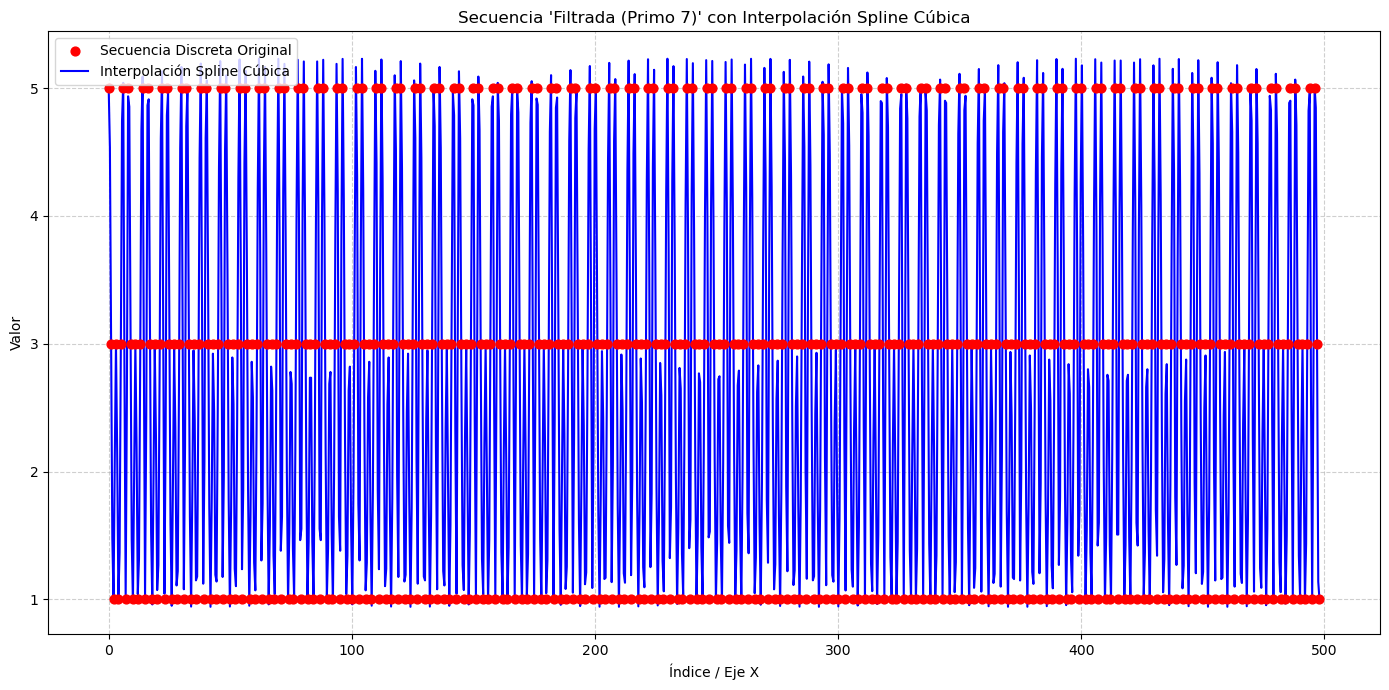


▶️ Iniciando análisis TDA para los tipos: ['discreta', 'spline3']

--- INICIANDO ANÁLISIS TDA PARA: Filtrada (Primo 7) - Discreta ---


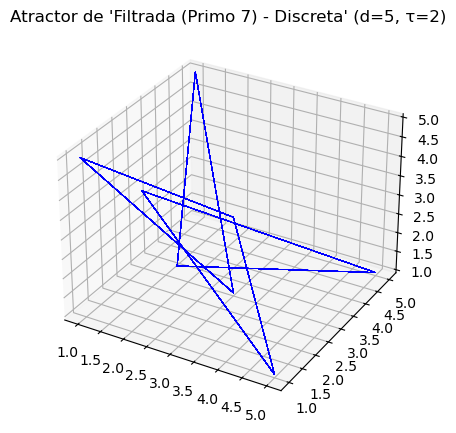

Análisis de persistencia se realizará en 491 puntos.


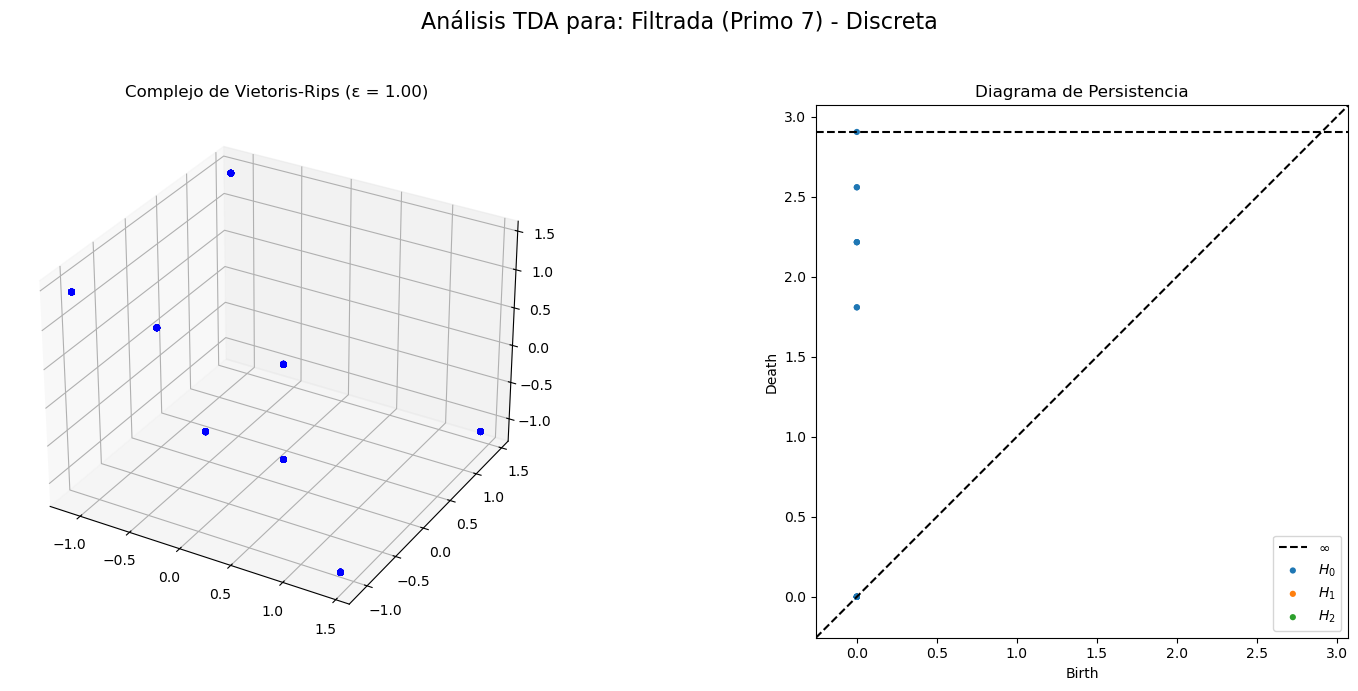

--- ANÁLISIS TDA FINALIZADO PARA: Filtrada (Primo 7) - Discreta ---

--- INICIANDO ANÁLISIS TDA PARA: Filtrada (Primo 7) - Spline Cúbica ---


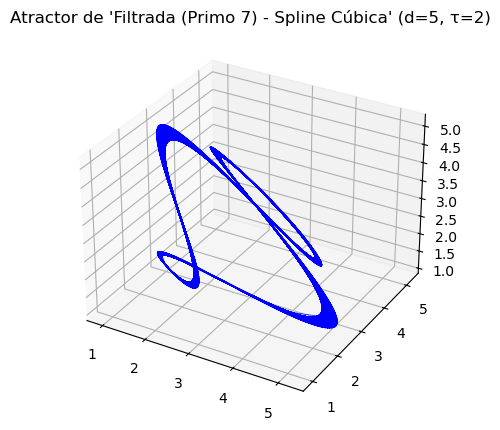

La nube de puntos (992) excede el máximo (750). Submuestreando...
Análisis de persistencia se realizará en 750 puntos.


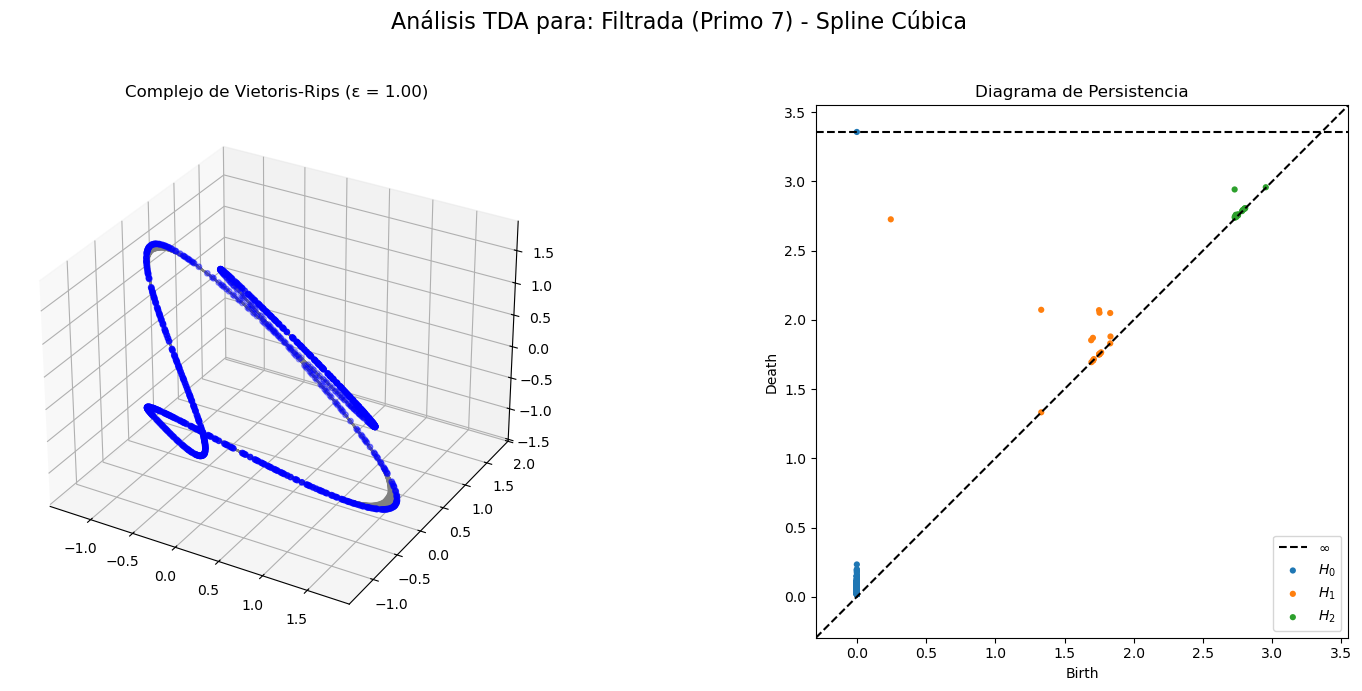

--- ANÁLISIS TDA FINALIZADO PARA: Filtrada (Primo 7) - Spline Cúbica ---

✅ Análisis para 'Filtrada (Primo 7)' finalizado.


In [12]:
# ==============================================================================
# BLOQUE DE EJECUCIÓN PRINCIPAL
# ==============================================================================
if __name__ == '__main__':
    # --- 1. Parámetros de Configuración ---
    PARAMETROS_TDA = {
        "puntos_interpolacion": 1000,
        "dim_emb": 5,
        "tau_emb": 2,
        "epsilon_vr": 1.0,
        "num_componentes_trig": 50,
        "max_puntos_tda": 750,
        "semilla": 42
    }

    # --- 2. Elige la Secuencia a Analizar ---
    # Descomenta la línea de la secuencia que quieras usar:
    secuencia_a_analizar = generar_secuencia_filtrada(primo_base=7, longitud_deseada=500)
    nombre = "Filtrada (Primo 7)"

    # secuencia_a_analizar = generar_secuencia_diferencia_primos(n_primos=500)
    # nombre = "Diferencia de Primos"

    # secuencia_a_analizar = generar_secuencia_xor_primos_naturales(n_elementos=500)
    # nombre = "XOR Primos y Naturales"


    # --- 3. Elige qué Análisis Realizar ---
    ejecutar_analisis_completo(
        secuencia_discreta=secuencia_a_analizar,
        nombre_secuencia=nombre,
        # Aquí eliges qué versiones de la secuencia analizar:
        tipos_TDA=['discreta', 'spline3'], # <--- ¡MODIFICA ESTA LISTA!
        **PARAMETROS_TDA
    )